First audio feature extraction practice     
refer to
  
https://www.kaggle.com/code/utcarshagrawal/birdclef-audio-pytorch-tutorial     

note(korean)    
https://goodfingers.notion.site/BirdCLEF-Audio-PyTorch-Tutorial-5dc97cf9d05042ac8efedccd5ad5d560


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import

In [2]:
import os
import gc
import ast
import random
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
import torchaudio
import IPython.display as ipd
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from typing import List

import warnings
warnings.filterwarnings('ignore')

In [3]:
class config:
    seed=2022
    num_fold = 5
    sample_rate= 32_000
    n_fft=1024
    hop_length=512
    n_mels=64
    duration=7
    num_classes = 152
    train_batch_size = 32
    valid_batch_size = 64
    model_name = 'resnet50'
    epochs = 2
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    learning_rate = 1e-4

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(config.seed)

In [5]:
ROOTDIR = "../input/birdclef-2022"

In [6]:
train_df = pd.read_csv(f'{ROOTDIR}/train_metadata.csv')
train_df.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename
0,afrsil1,[],"['call', 'flight call']",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:00,https://www.xeno-canto.org/125458,afrsil1/XC125458.ogg
1,afrsil1,"['houspa', 'redava', 'zebdov']",['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,Dan Lane,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:30,https://www.xeno-canto.org/175522,afrsil1/XC175522.ogg
2,afrsil1,[],"['call', 'song']",16.2901,-16.0321,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:30,https://www.xeno-canto.org/177993,afrsil1/XC177993.ogg
3,afrsil1,[],"['alarm call', 'call']",17.0922,54.2958,Euodice cantans,African Silverbill,Oscar Campbell,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:00,https://www.xeno-canto.org/205893,afrsil1/XC205893.ogg
4,afrsil1,[],['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,3.0,16:30,https://www.xeno-canto.org/207431,afrsil1/XC207431.ogg


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14852 entries, 0 to 14851
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   primary_label     14852 non-null  object 
 1   secondary_labels  14852 non-null  object 
 2   type              14852 non-null  object 
 3   latitude          14852 non-null  float64
 4   longitude         14852 non-null  float64
 5   scientific_name   14852 non-null  object 
 6   common_name       14852 non-null  object 
 7   author            14852 non-null  object 
 8   license           14852 non-null  object 
 9   rating            14852 non-null  float64
 10  time              14852 non-null  object 
 11  url               14852 non-null  object 
 12  filename          14852 non-null  object 
dtypes: float64(3), object(10)
memory usage: 1.5+ MB


In [8]:
train_df.describe()

,latitude,longitude,rating
count,14852.000000,14852.000000,14852.000000
mean,35.778958,-30.217719,3.719129
std,22.288169,73.679144,1.181014
min,-71.883400,-176.632200,0.000000
25%,28.259200,-96.164300,3.000000
50%,40.870800,-6.061100,4.000000
75%,51.121950,10.897800,4.500000
max,78.978300,179.360700,5.000000


## Quick EDA

### Checking data distribution

#### make class for visualization

In [9]:
class Dataviz():
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.meta = pd.read_csv(fr"{self.root_dir}/train_metadata.csv")
        self.meta['type'] = self.meta['type'].apply(lambda x : ast.literal_eval(x))
    
    
    def feature_distribution(self, feature: str):
        plt.figure(figsize=(20, 6))

        sns.countplot(self.meta[feature])
        plt.xticks(rotation=90)
        plt.title(f"Distribution of {feature} Labels", fontsize=20)

        plt.show()
        
    
    def most_common(self, feature: str, k: int):
        
        if isinstance(self.meta[feature].iloc[0], list):
    
            top = Counter([typ.lower() for lst in self.meta[feature] 
                                           for typ in lst])

            top = dict(top.most_common(k))

            plt.figure(figsize=(20, 6))

            sns.barplot(x=list(top.keys()), y=list(top.values()), palette='hls')
            plt.title(f"Top {k} song {feature}")

            
        else:
            top = Counter([f.lower() for f in self.meta[feature]])

            top = dict(top.most_common(k))

            plt.figure(figsize=(20, 6))

            sns.barplot(x=list(top.keys()), y=list(top.values()), palette='hls')
            plt.title(f"Top {k} song {feature}")

        plt.show()
            

In [10]:
train_viz = Dataviz('../input/birdclef-2022/')

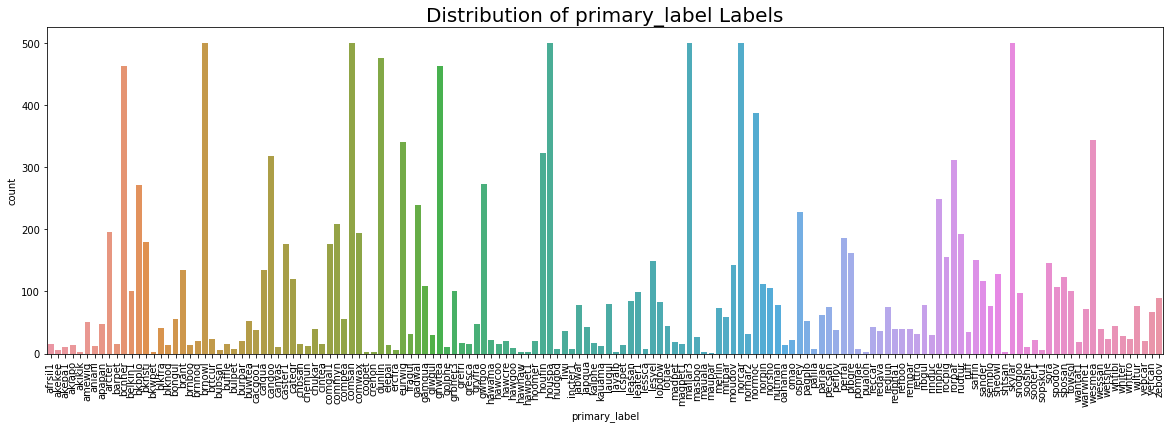

In [11]:
train_viz.feature_distribution("primary_label")

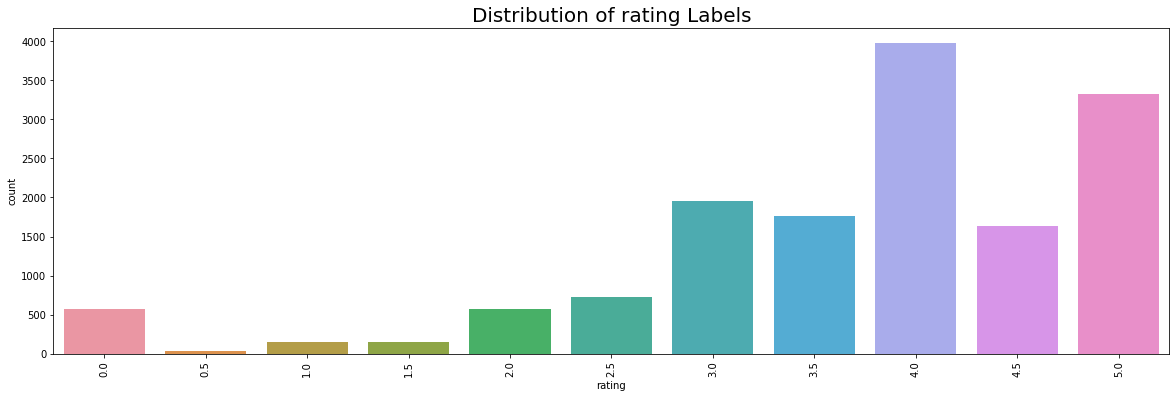

In [12]:
train_viz.feature_distribution("rating")

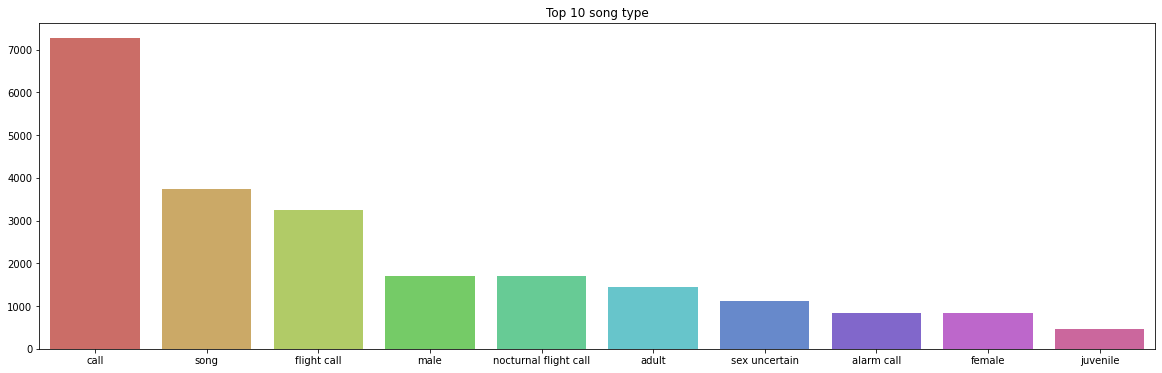

In [13]:
train_viz.most_common("type", 10)

# Analysis audio files

## Play a few samples

In [14]:
filename_1 = train_df["filename"].values[0] # first training example
ipd.Audio(f"../input/birdclef-2022/train_audio/{filename_1}")

In [15]:
filename_2 = train_df["filename"].values[-1] # last training example
ipd.Audio(f"../input/birdclef-2022/train_audio/{filename_2}")

### waveform

#### add a method for visualizing waveform to DataViz class 

In [16]:
class Dataviz():
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.meta = pd.read_csv(fr"{self.root_dir}/train_metadata.csv")
        self.meta['type'] = self.meta['type'].apply(lambda x : ast.literal_eval(x))
    
    
    def feature_distribution(self, feature: str):
        plt.figure(figsize=(20, 6))

        sns.countplot(self.meta[feature])
        plt.xticks(rotation=90)
        plt.title(f"Distribution of {feature} Labels", fontsize=20)

        plt.show()
        
    
    def most_common(self, feature: str, k: int):
        
        if isinstance(self.meta[feature].iloc[0], list):
    
            top = Counter([typ.lower() for lst in self.meta[feature] 
                                           for typ in lst])

            top = dict(top.most_common(k))

            plt.figure(figsize=(20, 6))

            sns.barplot(x=list(top.keys()), y=list(top.values()), palette='hls')
            plt.title(f"Top {k} song {feature}")
            
        else:
            top = Counter([f.lower() for f in self.meta[feature]])

            top = dict(top.most_common(k))

            plt.figure(figsize=(20, 6))

            sns.barplot(x=list(top.keys()), y=list(top.values()), palette='hls')
            plt.title(f"Top {k} song {feature}")

        plt.show()
            
    
    
    def waveform(self, indices: List[str]):
        if isinstance(indices, int):
            indices = [indices]
        n = len(indices)
                                  
        if n == 1:    
            idx = indices[0]
            fig, ax = plt.subplots(1, 1, figsize=(20, 5))
            fig.suptitle("Sound Waves", fontsize=15)
            
            signal_1, sample_rate = torchaudio.load(f"{self.root_dir}/train_audio/{self.meta.filename.iloc[idx]}")
            # The audio data consist of two things-
            # Sound: sequence of vibrations in varying pressure strengths (y)
            # Sample Rate: (sample_rate) is the number of samples of audio carried per second, measured in Hz or kHz

            sns.lineplot(x=np.arange(len(signal_1[0,:].detach().numpy())), y=signal_1[0,:].detach().numpy(), ax=ax, color='#4400FF')
            ax.set_title(f"Audio {idx}")
        
        elif n > 1:
            fig, ax = plt.subplots(n, 1, figsize=(20, 5 * n))
            fig.suptitle("Sound Waves", fontsize=15)
            
            for i, idx in enumerate(indices):

                signal, sample_rate = torchaudio.load(f"{self.root_dir}/train_audio/{self.meta.filename.iloc[idx]}")
                # The audio data consist of two things-
                # Sound: sequence of vibrations in varying pressure strengths (y)
                # Sample Rate: (sample_rate) is the number of samples of audio carried per second, measured in Hz or kHz

                sns.lineplot(x=np.arange(len(signal[0,:].detach().numpy())), y=signal[0,:].detach().numpy(), ax=ax[i], color='#4400FF')
                ax[i].set_title(f"Audio {idx}")

        else:
            print("n should be more than or equal to 1")
            assert n >= 1
            
        plt.show()

In [17]:
train_viz = Dataviz('../input/birdclef-2022/')

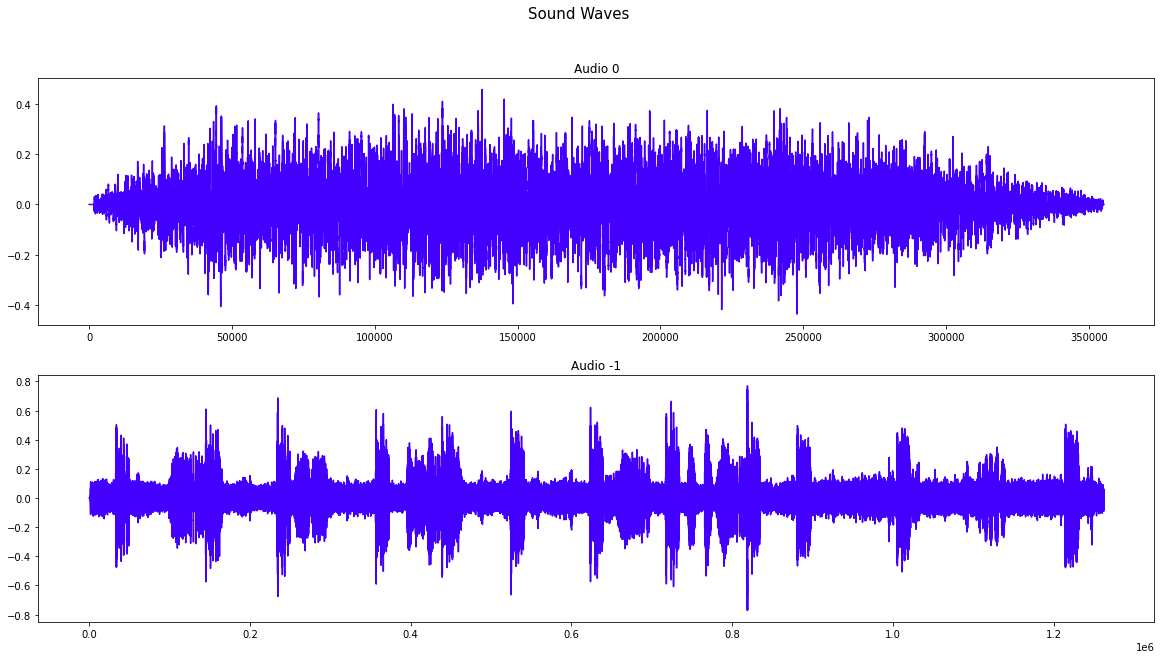

In [18]:
train_viz.waveform([0, -1])

# Dataset preprocessing

## Convert target which is in string format to integer using LabelEncoder

In [19]:
encoder = LabelEncoder()
train_df['primary_label_encoded'] = encoder.fit_transform(train_df['primary_label'])

In [20]:
skf = StratifiedKFold(n_splits=config.num_fold)
for k, (_, val_ind) in enumerate(skf.split(X=train_df, y=train_df['primary_label_encoded'])):
    train_df.loc[val_ind, 'fold'] = k

## feature extraction

In [21]:
class Dataviz():
    def __init__(self, sample_rate, n_fft, hop_length, n_mels):
        self.root_dir = ROOTDIR
        self.meta = pd.read_csv(fr"{self.root_dir}/train_metadata.csv")
        self.meta['type'] = self.meta['type'].apply(lambda x : ast.literal_eval(x))
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        
        self.mel_converter = torchaudio.transforms.MelSpectrogram(sample_rate=self.sample_rate, 
                                                              n_fft=self.n_fft, 
                                                              hop_length=self.hop_length, 
                                                              n_mels=self.n_mels)
    
    
    def feature_distribution(self, feature: str):
        plt.figure(figsize=(20, 6))

        sns.countplot(self.meta[feature])
        plt.xticks(rotation=90)
        plt.title(f"Distribution of {feature} Labels", fontsize=20)

        plt.show()
        
    
    def most_common(self, feature: str, k: int):
        
        if isinstance(self.meta[feature].iloc[0], list):
    
            top = Counter([typ.lower() for lst in self.meta[feature] 
                                           for typ in lst])

            top = dict(top.most_common(k))

            plt.figure(figsize=(20, 6))

            sns.barplot(x=list(top.keys()), y=list(top.values()), palette='hls')
            plt.title(f"Top {k} song {feature}")
            
        else:
            top = Counter([f.lower() for f in self.meta[feature]])

            top = dict(top.most_common(k))

            plt.figure(figsize=(20, 6))

            sns.barplot(x=list(top.keys()), y=list(top.values()), palette='hls')
            plt.title(f"Top {k} song {feature}")

        plt.show()
            
    
    def waveform(self, indices: List[str]):
        if isinstance(indices, int):
            indices = [indices]
        n = len(indices)
                                  
        if n == 1:    
            idx = indices[0]
            fig, ax = plt.subplots(1, 1, figsize=(20, 5))
            fig.suptitle("Sound Waves", fontsize=15)
            
            signal_1, sample_rate = torchaudio.load(f"{self.root_dir}/train_audio/{self.meta.filename.iloc[idx]}")
            # The audio data consist of two things-
            # Sound: sequence of vibrations in varying pressure strengths (y)
            # Sample Rate: (sample_rate) is the number of samples of audio carried per second, measured in Hz or kHz

            sns.lineplot(x=np.arange(len(signal_1[0,:].detach().numpy())), y=signal_1[0,:].detach().numpy(), ax=ax, color='#4400FF')
            ax.set_title(f"Audio {idx}")
        
        elif n > 1:
            fig, ax = plt.subplots(n, 1, figsize=(20, 5 * n))
            fig.suptitle("Sound Waves", fontsize=15)
            
            for i, idx in enumerate(indices):

                signal, sample_rate = torchaudio.load(f"{self.root_dir}/train_audio/{self.meta.filename.iloc[idx]}")
                # The audio data consist of two things-
                # Sound: sequence of vibrations in varying pressure strengths (y)
                # Sample Rate: (sample_rate) is the number of samples of audio carried per second, measured in Hz or kHz

                sns.lineplot(x=np.arange(len(signal[0,:].detach().numpy())), y=signal[0,:].detach().numpy(), ax=ax[i], color='#4400FF')
                ax[i].set_title(f"Audio {idx}")

        else:
            print("n should be more than or equal to 1")
            assert n >= 1
            
        plt.show()
        
    
    def mel_spectrogram(self, indices: List[str]):
        
        if isinstance(indices, int):
            indices = [indices]
            
        n = len(indices)
                                  
        if n == 1:    
            idx = indices[0]
            fig, ax = plt.subplots(1, 1, figsize=(10, 7))
            fig.suptitle("Mel Spectrogram", fontsize=15)
            
            signal, sample_rate = torchaudio.load(f"{self.root_dir}/train_audio/{self.meta.filename.iloc[idx]}")
            # The audio data consist of two things-
            # Sound: sequence of vibrations in varying pressure strengths (y)
            # Sample Rate: (sample_rate) is the number of samples of audio carried per second, measured in Hz or kHz
            
            mel = self.mel_converter(signal)

            ax.imshow(mel.log2()[0,:,:].detach().numpy(), aspect='auto', cmap='cool')
            ax.set_title(f"Audio {idx}")
                    
        elif n > 1:
            fig, ax = plt.subplots(n, 1, figsize=(10,  7 * n))
            fig.suptitle("Mel Spectrogram", fontsize=15)
            
            for i, idx in enumerate(indices):

                signal, sample_rate = torchaudio.load(f"{self.root_dir}/train_audio/{self.meta.filename.iloc[idx]}")
                # The audio data consist of two things-
                # Sound: sequence of vibrations in varying pressure strengths (y)
                # Sample Rate: (sample_rate) is the number of samples of audio carried per second, measured in Hz or kHz

                mel = self.mel_converter(signal)
                ax[i].imshow(mel.log2()[0,:,:].detach().numpy(), aspect='auto', cmap='cool')
                ax[i].set_title(f"Audio {idx}")

        else:
            print("n should be more than or equal to 1")
            assert n >= 1
            
        plt.show()
            

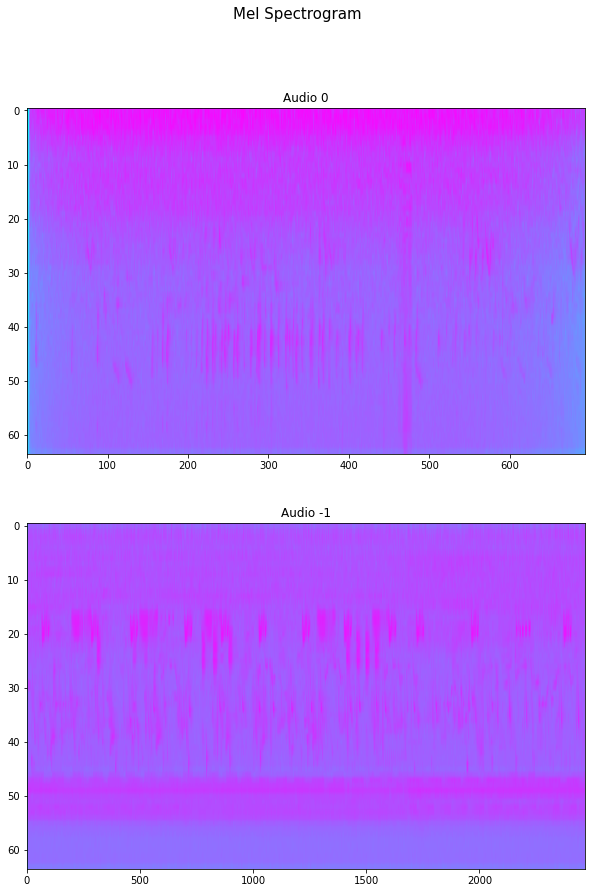

In [22]:
train_viz = Dataviz(sample_rate=config.sample_rate, n_fft=config.n_fft, hop_length=config.hop_length, n_mels=config.n_mels)
train_viz.mel_spectrogram([0, -1])

- all data need to have same sample rate => resample the data so that all the data have same sample rate     
- if we talk about the sound => the dimension of sound is (n_channels, n_samples)      
  if we talk about the channels => each audio can have different channel, so we will ensure that they are mono(n_channels == 1)     
- each audio signal have different time durations which lead to difference in number of samples.    
  => ensure same number of samples by applying padding if it less than the desired samples or by truncating if it is more than the desired samples

In [23]:
class BirdClefDataset(Dataset, Dataviz):
    
    def __init__(self, root_dir, sample_rate, n_fft, hop_length, n_mels, duration):
        self.root_dir = ROOTDIR
        self.meta = pd.read_csv(fr"{self.root_dir}/train_metadata.csv")
        
        self.meta['type'] = self.meta['type'].apply(lambda x : ast.literal_eval(x))
        encoder = LabelEncoder()
        self.meta['primary_label_encoded'] = encoder.fit_transform(self.meta['primary_label'])
        
        self.audio_paths = self.root_dir + "/" + "train_audio" + "/" + self.meta.filename.values
        self.labels = self.meta.primary_label_encoded.values
        
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.num_samples = sample_rate * duration
        
        self.mel_converter = torchaudio.transforms.MelSpectrogram(sample_rate=self.sample_rate, 
                                                              n_fft=self.n_fft, 
                                                              hop_length=self.hop_length, 
                                                              n_mels=self.n_mels)
        
    def __len__(self):
        return len(self.audio_paths)
    
    
    def __getitem__(self, idx):
        audio_path = self.audio_paths[idx]
        signal, sample_rate = torchaudio.load(audio_path) # loaded the audio
        
        # Now we first checked if the sample rate is same as TARGET_SAMPLE_RATE and if it not equal we perform resampling
        if sample_rate != self.sample_rate:
            resampler = torchaudio.transforms.Resample(sample_rate, self.sample_rate)
            signal = resampler(signal)
        
        # Next we check the number of channels of the signal
        #signal -> (num_channels, num_samples) - Eg.-(2, 14000) -> (1, 14000)
        if signal.shape[0]>1:
            signal = torch.mean(signal, axis=0, keepdim=True)
        
        # Lastly we check the number of samples of the signal
        #signal -> (num_channels, num_samples) - Eg.-(1, 14000) -> (1, self.num_samples)
        # If it is more than the required number of samples, we truncate the signal
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        
        # If it is less than the required number of samples, we pad the signal
        if signal.shape[1] < self.num_samples:
            num_missing_samples = self.num_samples - signal.shape[1]
            last_dim_padding = (0, num_missing_samples)
            signal = F.pad(signal, last_dim_padding)
        
        # Finally all the process has been done and now we will extract mel spectrogram from the signal
        mel = self.mel_converter(signal)
        
        # For pretrained models, we need 3 channel image, so for that we concatenate the extracted mel
        image = torch.cat([mel, mel, mel])
        
        # Normalized the image
        max_val = torch.abs(image).max()
        image = image / max_val
        
        label = torch.tensor(self.labels[idx])
        
        return image, label

In [24]:
# Function to get data according to the folds
def get_data(df, fold):
    train_df = df[df['fold'] != fold].reset_index(drop=True)
    valid_df = df[df['fold'] == fold].reset_index(drop=True)
    train_dataset = BirdClefDataset(train_df, sample_rate=config.sample_rate, n_fft=config.n_fft, hop_length=config.hop_length, n_mels=config.n_mels, duration=config.duration)
    valid_dataset = BirdClefDataset(valid_df, sample_rate=config.sample_rate, n_fft=config.n_fft, hop_length=config.hop_length, n_mels=config.n_mels, duration=config.duration)
    
    train_loader = DataLoader(train_dataset, batch_size=config.train_batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=config.valid_batch_size, shuffle=False)
    
    return train_loader, valid_loader

# Model

## Simple cnn

In [25]:
class BirdClefModel(nn.Module):
    def __init__(self):
        super(BirdClefModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128*8*54, 64)
        self.fc2 = nn.Linear(64, config.num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

## pretrained resnet

In [26]:
class BirdCLEFResnet(nn.Module):
    def __init__(self):
        super(BirdCLEFResnet, self).__init__()
        self.base_model = models.__getattribute__(config.model_name)(pretrained=True)
        for param in self.base_model.parameters():
            param.requires_grad = False
            
        in_features = self.base_model.fc.in_features
        
        self.base_model.fc = nn.Sequential(
            nn.Linear(in_features, 1024), 
            nn.ReLU(), 
            nn.Dropout(p=0.2),
            nn.Linear(1024, 512), 
            nn.ReLU(), 
            nn.Dropout(p=0.2),
            nn.Linear(512, config.num_classes))
        
    def forward(self, x):
        x = self.base_model(x)
        return x

# Utility Functions

In [27]:
def loss_fn(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

def train(model, data_loader, optimizer, scheduler, device, epoch):
    model.train()
    
    running_loss = 0
    loop = tqdm(data_loader, position=0)
    for i, (mels, labels) in enumerate(loop):
        mels = mels.to(device)
        labels = labels.to(device)
        
        outputs = model(mels)
        _, preds = torch.max(outputs, 1)
        
        loss = loss_fn(outputs, labels)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if scheduler is not None:
            scheduler.step()
            
        running_loss += loss.item()
        
        loop.set_description(f"Epoch [{epoch+1}/{config.epochs}]")
        loop.set_postfix(loss=loss.item())

    return running_loss/len(data_loader)

In [28]:
def valid(model, data_loader, device, epoch):
    model.eval()
    
    running_loss = 0
    pred = []
    label = []
    
    loop = tqdm(data_loader, position=0)
    for mels, labels in loop:
        mels = mels.to(device)
        labels = labels.to(device)
        
        outputs = model(mels)
        _, preds = torch.max(outputs, 1)
        
        loss = loss_fn(outputs, labels)
            
        running_loss += loss.item()
        
        pred.extend(preds.view(-1).cpu().detach().numpy())
        label.extend(labels.view(-1).cpu().detach().numpy())
        
        loop.set_description(f"Epoch [{epoch+1}/{config.epochs}]")
        loop.set_postfix(loss=loss.item())
        
    valid_f1 = f1_score(label, pred, average='macro')
    
    return running_loss/len(data_loader), valid_f1

In [29]:
def run(fold):
    train_loader, valid_loader = get_data(train_df, fold)
    
    #model = BirdClefModel().to(config.device) # check version 3 for this
    model = BirdCLEFResnet().to(config.device)
    
    optimizer = Adam(model.parameters(), lr=config.learning_rate)
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=1e-5, T_max=10)
    
    best_valid_f1 = 0
    for epoch in range(config.epochs):
        train_loss = train(model, train_loader, optimizer, scheduler, config.device, epoch)
        valid_loss, valid_f1 = valid(model, valid_loader, config.device, epoch)
        if valid_f1 > best_valid_f1:
            print(f"Validation F1 Improved - {best_valid_f1} ---> {valid_f1}")
            torch.save(model.state_dict(), f'./model_{fold}.bin')
            print(f"Saved model checkpoint at ./model_{fold}.bin")
            best_valid_f1 = valid_f1
            
    return best_valid_f1

In [30]:
for fold in range(config.num_fold):
    print("=" * 30)
    print("Training Fold - ", fold)
    print("=" * 30)
    best_valid_f1 = run(fold)
    print(f'Best F1 Score: {best_valid_f1:.5f}')
    
    gc.collect()
    torch.cuda.empty_cache()    
    break # To run for all the folds, just remove this break 

Training Fold -  0


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch [1/2]: 100%|██████████| 233/233 [47:15<00:00, 12.17s/it, loss=4.85]


Validation F1 Improved - 0 ---> 0.00699577322286401
Saved model checkpoint at ./model_0.bin


Epoch [2/2]: 100%|██████████| 233/233 [47:15<00:00, 12.17s/it, loss=4.63]


Validation F1 Improved - 0.00699577322286401 ---> 0.021296294829994903
Saved model checkpoint at ./model_0.bin
Best F1 Score: 0.02130
